# Deux conteneurs
## filebench : filemicro_seqread vs filemicro_seqreadone_randreadother
### Tester la soft limite
#### Description
Cette expérience fait suite à la première lancée avec deux conteneurs.

On se place dans un scénario où deux conteneurs (B et A) exécutant des charges de travail différentes (`filemicro_seqreadone_randreadother` qui sera détaillée plus tard et `filemicro_seqread` avec un fichier de 2GB) sont lancés et où l'administrateur système ne sait pas trop comment fixer cette limite. Il y aura donc plusieurs cas :

1. Le premier dans lequel les deux conteneurs ont une `soft` limite égale à 1GB.
2. Le deuxième dans lequel les deux conteneurs ont une `soft` limite égale 1.5GB (soit la moitié de la mémoire de la machine).
3. Le troisième dans lequel le conteneur exécutant la charge de travail `filemicro_seqreadone_randreadother` voit sa limite fixée à 2GB et l'autre à 1GB (deux tiers pour l'un et un tiers pour l'autre).
4. Le quatrième est l'inverse du troisième.
5. Le cinquième dans lequel le conteneur exécutant la charge de travail `filemicro_seqread` voit sa `soft` limite fixée à 2.5GB tandis que l'autre conteneur a une `soft` limite fixée à .5GB.
6. Le sixième est l'inverse du cinquième.
7. Le dernier dans lequel les conteneurs ont tous deux une `soft` limite fixée à 2.5GB.

#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Chaque conteneur est lancé avec une `max` limite fixée à 3GB. Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

Les différentes charges de travail sont exécutées dans `/tmp` qui appartient à un volume ayant pour système de fichier `ext4fs`.

#### filemicro_seqreadone_randreadother
Pour cette expérience une charge de travail nommée `filemicro_seqreadone_randreadother` a été développée.

Cette charge de travail consiste à lire deux fichiers de tailles très différentes (1GB contre 10GB de base). À chaque itération les deux fichiers sont lus avec un pas de 1MB mais le plus gros fichier est lu aléatoirement tandis que le plus petit est lu séquentiellement.

L'algorithme est le suivant :
```
#
# CDDL HEADER START
#
# The contents of this file are subject to the terms of the
# Common Development and Distribution License (the "License").
# You may not use this file except in compliance with the License.
#
# You can obtain a copy of the license at usr/src/OPENSOLARIS.LICENSE
# or http://www.opensolaris.org/os/licensing.
# See the License for the specific language governing permissions
# and limitations under the License.
#
# When distributing Covered Code, include this CDDL HEADER in each
# file and include the License file at usr/src/OPENSOLARIS.LICENSE.
# If applicable, add the following below this CDDL HEADER, with the
# fields enclosed by brackets "[]" replaced with your own identifying
# information: Portions Copyright [yyyy] [name of copyright owner]
#
# CDDL HEADER END
#
#
# Copyright 2008 Sun Microsystems, Inc.  All rights reserved.
# Use is subject to license terms.
#
# ident	"%Z%%M%	%I%	%E% SMI"

# Single threaded sequential reads (1MB I/Os) on a 1G file then on a 10G file.

# Global defines.
set $dir=/tmp
set $cached=false
set $iosize=1m
set $nthreads=1

# Specific defines.
set $small_filesize=1g
set $large_filesize=10g

define file name=smallfile,path=$dir,size=$small_filesize,prealloc,reuse,cached=$cached
define file name=largefile,path=$dir,size=$large_filesize,prealloc,reuse,cached=$cached

define process name=filereader,instances=1
{
  thread name=filereaderthread,memsize=10m,instances=$nthreads
  {
    # We ABSOLUTELY need to precise the file descriptor for each operation or
    # the operations will be done one file descriptor 0...
    # The file descriptor 0 or filebench is not the same as the UNIX file
    # descriptor 0 (stdin).
    flowop read name=seqread_smallfile,filename=smallfile,iosize=$iosize,fd=0
    # Randomly read the big file.
    flowop read random,name=randread_largefile,filename=largefile,iosize=$iosize,fd=1
  }
}

echo  "FileMicro-SeqRead-EachOne Version 1.0 personality successfully loaded"
usage "Usage: set \$dir=<dir>"
usage "       set \$cached=<bool>    defaults to $cached"
usage "       set \$filesize=<size>  defaults to $filesize"
usage "       set \$iosize=<size>    defaults to $iosize"
usage "       set \$nthreads=<value> defaults to $nthreads"
usage "       set \$small_filesize=<value> default to $small_filesize"
usage "       set \$large_filesize=<value> default to $large_filesize"
usage " "
usage "       run runtime (e.g. run 60)"

run 30
```

#### Étude du code de `filebench`
Lors de lancement préliminaire au lancement de cette expérience un comportement étrange avait été rémarqué pour le conteneur B. En effet, celui-ci s'exécutait avec d'excellentes performances comme si le fichier accédé aléatoirement ne causait aucune lecture sur le disque.

Après conseil d'un collègue, étude du code et des logs de `filebench` il se trouve que ce benchmark effectue ses opérations sur le descripteur de fichier 0 par défaut. Pour forcer des opérations à accéder à des fichiers différents il faut donc renseigner explicitement ces descripteurs de fichiers.

#### Résultats attendus
Détaillons les résultats selon les cas étudiés :

1. Les deux conteneurs ne devraient pas avoir de bonnes performances car leur `soft` limite est inférieure à la taille des fichiers qu'ils manipulent.
2. Le conteneur B devrait avoir de meilleurs performances que le conteneur A car son petit fichier devrait tenir en mémoire.
3. Le conteneur B devrait avoir d'encore meilleurs performances que le conteneur A car sa `soft` limite est augmentée.
4. Le conteneur A devrait avoir de meilleurs performances que le conteneur B car les `soft` limites sont inversées.
5. Le conteneur A devrait avoir d'encore meilleurs performances que le conteneur B car sa `soft` limite est augmentée.
6. Le conteneur B devrait avoir de meilleurs performances que le conteneur A et de meilleurs performances par rapport à ses exécutions dans les autres cas.
7. Trois cas peuvent être envisagés :
    1. Soit le conteneur A est favorisé par le noyau et voit donc son empreinte mémoire se stabiliser à 2.5GB ce qui lui permettrait d'obtenir de bonnes performances.
    2. Soit le conteneur B est favorisé mais il n'obtiendra pas d'excellentes performances car 2.5GB ne lui suffisent pas.
    3. Soit aucun des conteneurs n'est favorisé et ils ont tous deux de mauvaises performances.

Il semble naturel que les performances des conteneurs lorsqu'ils sont exécutés avec une `soft` limite fixée à 1GB soient inférieures à celles obtenues lorsqu'ils voient leurs limites fixées à 1.5GB.

Dans le cas où les conteneurs n'ont pas la même limite les performances du conteneur disposant d'une `soft` limite plus élevées devraient être plus élevées.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Le script permettant de lancer les deux conteneurs en même temps et d'obtenir des statistiques sur ceux-ci est le suivant (une version ne lançant qu'un conteneur a aussi été écrite) :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
import sys
import docker
import os
import threading
import json

"""This python script will start two containers with filebench with the given as
argument soft limits.

It will then run 10 times the FILEBENCH_CONTAINER_A and FILEBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Filebench command for the container A.
FILEBENCH_CONTAINER_A = './filebench -f workloads/filemicro_seqread.f'

# Filebench command for the container B.
FILEBENCH_CONTAINER_B = './filebench -f workloads/filemicro_seqreadone_randreadother.f'

def thread_func(container, command, out, stats):
	"""Run the command in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container
	:param command: The command to run in container.
	:type command: str
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param out: An open in write file object where the stats of the container will
	be written.
	:type out: _io.TextIOWrapper
	"""
	gen = container.stats()

	# Run the benchmark inside the container and write the output to out.
	# exec_run returns a tuple whom second field contains bytes. The decode
	# translate them to a string.
	out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_read = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'usage': jason['memory_stats']['usage']}

		for io in jason['blkio_stats']['io_serviced_recursive']:
			if io['op'] == 'Read':
				# Get the difference between this iteration and the previous one.
				# The value is so the number of read for this second. It can be seen
				# as the bandwith.
				val = io['value'] - old_read

				# Update the old value. Since it begins at 0 the first value will be
				# quite wrong but I do not think it will be a big problem.
				old_read = io['value']

				# Little trick if the key is not already present.
				if 'reads' in chicandier:
					chicandier['reads'] += val
				else:
					chicandier['reads'] = val

		statistics.append(chicandier)

		# Our filebenches last 30 seconds so we just want 30 records since
		# containerd give stats every second.
		if len(statistics) == 30:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d;%d;%d\n' % (i, statistics[i]['usage'], statistics[i]['reads']))

def main():
	if len(sys.argv) != 3:
		sys.exit("Usage: %s soft_limit0 soft_limit1" % sys.argv[0])

	client = docker.from_env()

	# Launch containers as detached, set their max limits to 3G, their soft limits
	# to given arguments.
	container_a = client.containers.run('filebench', auto_remove = True, detach = True, mem_limit = '3G', mem_reservation = sys.argv[1])
	container_b = client.containers.run('filebench', auto_remove = True, detach = True, mem_limit = '3G', mem_reservation = sys.argv[2])

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run each benchmark once so their files will be prepared for the next times
	# and they will begin to read files approximately at the same time.
	container_a.exec_run(FILEBENCH_CONTAINER_A)
	container_b.exec_run(FILEBENCH_CONTAINER_B)

	# Drop the cache so the runs above does not have a consequence on the runs
	# below. It can be a good idea to separate our filebench experiment in two WSL
	# files: one for preparing the run (by creating file) and the other to
	# effectively run the benchmark.
	drop_cache.write(bytearray('3\n', 'utf-8'))

	a_out = open(os.path.expanduser('~/container_a_%s_%s.out' % (container_a.name, sys.argv[1])), 'w')
	b_out = open(os.path.expanduser('~/container_b_%s_%s.out' % (container_b.name, sys.argv[2])), 'w')

	a_stats = open(os.path.expanduser('~/container_a_%s_%s.stats' % (container_a.name, sys.argv[1])), 'w')
	b_stats = open(os.path.expanduser('~/container_b_%s_%s.stats' % (container_b.name, sys.argv[2])), 'w')

	a_stats.write('iteration;usage;reads\n')
	b_stats.write('iteration;usage;reads\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		# Prepare the threads which will run filebench inside the containers.
		threads.append(threading.Thread(target=thread_func, args=(container_a, FILEBENCH_CONTAINER_A, a_out, a_stats)))
		threads.append(threading.Thread(target=thread_func, args=(container_b, FILEBENCH_CONTAINER_B, b_out, b_stats)))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	container_a.stop()
	container_b.stop()

	a_out.close()
	b_out.close()

	a_stats.close()
	b_stats.close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ces scripts ont ensuite été exécutés depuis un script bash qui gère les différentes configuration de `soft` limite qui ont été listées dans la description :
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>

# Run the container pair with 3 soft limit configurations.
python3 advanced_test_soft_limit.py 1G 1G
echo 'Finished run 1G/1G!'
# It is better to use 1500M instead of 1.5G because docker-py will failed to
# translate 1.5 into an int and will raise an exception.
python3 advanced_test_soft_limit.py 1500M 1500M
echo 'Finished run 1.5G/1.5G!'
python3 advanced_test_soft_limit.py 1G 2G
echo 'Finished run 1G/2G!'
python3 advanced_test_soft_limit.py 2G 1G
echo 'Finished run 2G/1G!'
python3 advanced_test_soft_limit.py 2500M 500M
echo 'Finished run 2.5G/.5G!'
python3 advanced_test_soft_limit.py 500M 2500M
echo 'Finished run .5G/2.5G!'
python3 advanced_test_soft_limit.py 2500M 2500M
echo 'Finished run 2.5G/2.5G!'

for s in 500M 1G 1500M 2G 2500M; do
	python3 advanced_test_soft_limit_alone.py filemicro_seqread.f $s
	echo "Finished run filemicro_seqread.f with ${s}!"

	python3 advanced_test_soft_limit_alone.py filemicro_seqreadone_randreadother.f $s
	echo "Finished run filemicro_seqreadone_randreadother.f with ${s}!"
done
```

#### Résultats obtenus
Les conteneurs sont d'abord exécutés seuls afin d'obtenir leurs meilleures performances possibles puis ensemble.

Pour chaque conteneur, ses performances sont obtenues en mesurant le nombre de lecture effectuées dans le/les fichiers. Pendant l'exécution des conteneurs, leurs empreintes mémoires (en octet) ainsi que leurs nombres de lectures effectuées depuis le disque ont été collectées chaque seconde. Des moyennes et leurs écarts-types associés ont été calculés pour chaque seconde.

**Le point 0 est parfois omis car son écart-type présente des valeurs étranges pour des raisons techniques un peu complexes mais qui n'ont pas d'impact sur les expériences.**

##### Conteneur A seul
Le conteneur A exécute la charge de travail `filemicro_seqread` avec un fichier de 2GB :

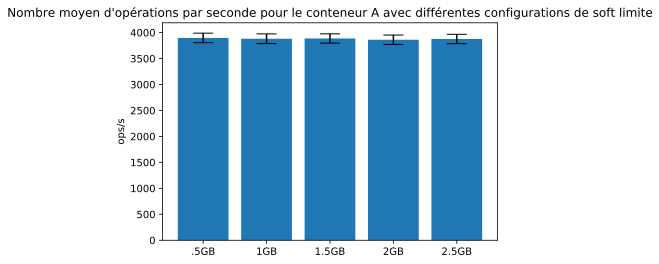

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'filemicro_seqread_alone'
FILES = ['%s/filemicro_seqread.f_alone_500M.out.csv' % DIR, '%s/filemicro_seqread.f_alone_1G.out.csv' % DIR, '%s/filemicro_seqread.f_alone_1500M.out.csv' % DIR, '%s/filemicro_seqread.f_alone_2G.out.csv' % DIR, '%s/filemicro_seqread.f_alone_2500M.out.csv' % DIR]

means = []
stds = []

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values

    means.append(values.mean(0)[1])
    stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['.5GB', '1GB', '1.5GB', '2GB', '2.5GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr = stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title("Nombre moyen d'opérations par seconde pour le conteneur A avec différentes configurations de soft limite")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

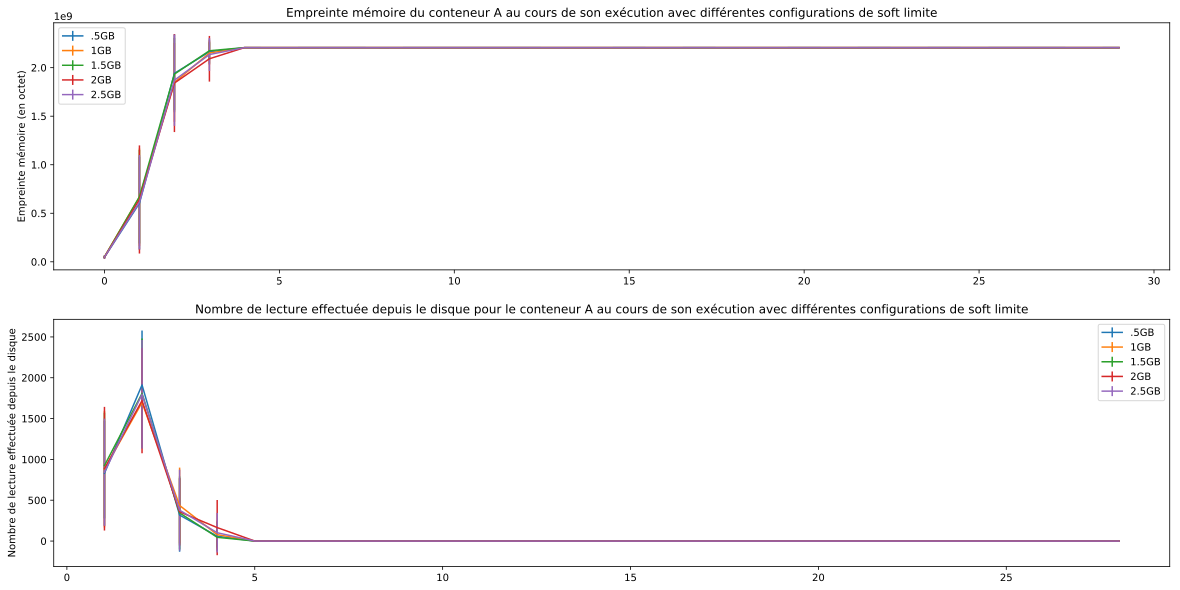

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

LABELS = ['.5GB', '1GB', '1.5GB', '2GB', '2.5GB']

DIR = 'filemicro_seqread_alone'
FILES = ['%s/filemicro_seqread.f_alone_500M.stats.csv' % DIR, '%s/filemicro_seqread.f_alone_1G.stats.csv' % DIR, '%s/filemicro_seqread.f_alone_1500M.stats.csv' % DIR, '%s/filemicro_seqread.f_alone_2G.stats.csv' % DIR, '%s/filemicro_seqread.f_alone_2500M.stats.csv' % DIR]

usage_means = []
usage_stds = []

reads_means = []
reads_stds = []

# xtick labels for the bar chart.
x_pos = np.arange(len(range(30)))

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    usage_means.append(values.take(1, axis = 1))
    usage_stds.append(values.take(2, axis = 1))
    
    # The first record has strange standard deviation values so we do not get it.
    reads_means.append(values.take(3, axis = 1)[1 : len(x_pos) - 1])
    reads_stds.append(values.take(4, axis = 1)[1 : len(x_pos) - 1])


# Axis and figure initialization.
# We need two axis: one for memory usage and the other for reads from disk.
fig, (usage_ax, reads_ax) = plt.subplots(nrows = 2, figsize = (20, 10))

for i in range(len(LABELS)):
    usage_ax.errorbar(x_pos, usage_means[i], yerr = usage_stds[i], label = LABELS[i])
    
    reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], reads_means[i], yerr = reads_stds[i], label = LABELS[i])
    
usage_ax.legend()
usage_ax.set_ylabel('Empreinte mémoire (en octet)')
usage_ax.set_title('Empreinte mémoire du conteneur A au cours de son exécution avec différentes configurations de soft limite')
    
reads_ax.legend()
reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur A au cours de son exécution avec différentes configurations de soft limite')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Quand le conteneur est exécuté seul il ne semble pas subir de pression mémoire et son nombre d'opérations par seconde se situe en dessous de 4000. Les écarts-types sont assez faibles preuve que les résultats sont stables.

L'empreinte mémoire du conteneur A semble être d'environ 2.3GB.

Le conteneur fait au début de son exécution beaucoup de lecture depuis le disque afin de ramener le fichier qu'il va lire. Puisque ce fichier tient en mémoire il n'a pas besoin de refaire de lecture depuis le disque d'où le nombre de lecture nul pour la suite de son exécution.

##### Conteneur B seul
Le conteneur B exécute la charge de travail `filemicro_seqreadone_randreadother` qui a été décrite plus haut :

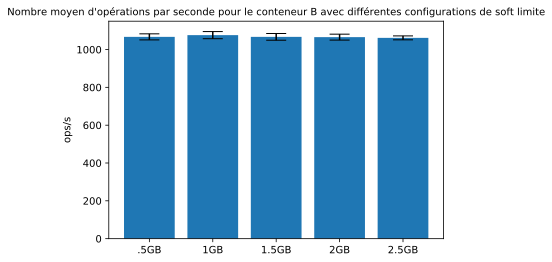

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'filemicro_seqreadone_randreadother_alone'
FILES = ['%s/filemicro_seqreadone_randreadother.f_alone_500M.out.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_1G.out.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_1500M.out.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_2G.out.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_2500M.out.csv' % DIR]

means = []
stds = []

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values

    means.append(values.mean(0)[1])
    stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['.5GB', '1GB', '1.5GB', '2GB', '2.5GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr = stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title("Nombre moyen d'opérations par seconde pour le conteneur B avec différentes configurations de soft limite")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

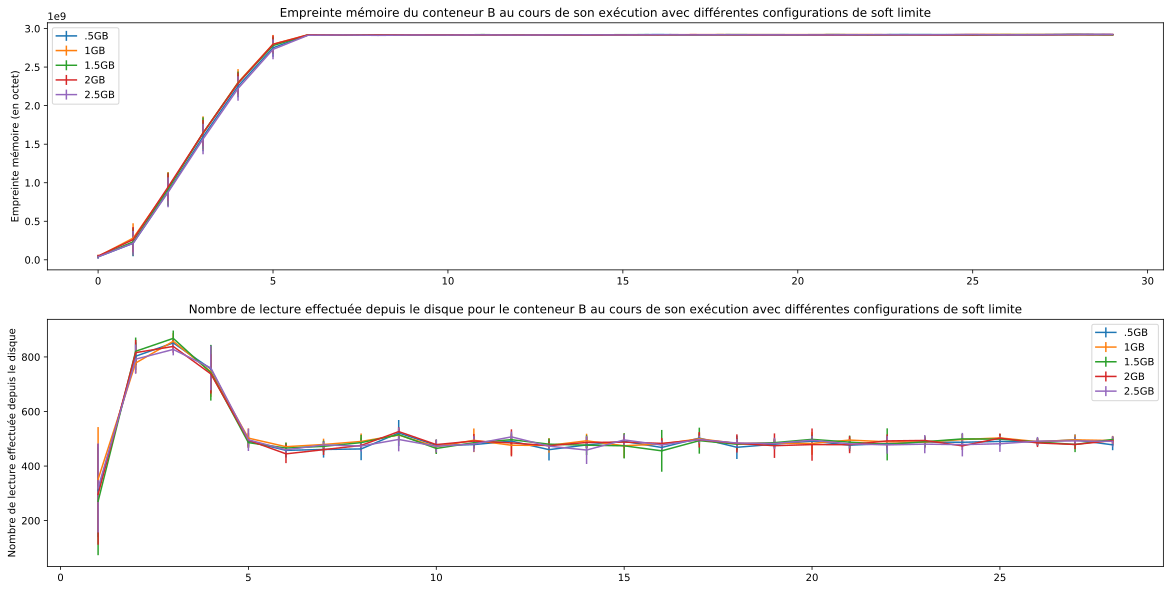

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

LABELS = ['.5GB', '1GB', '1.5GB', '2GB', '2.5GB']

DIR = 'filemicro_seqreadone_randreadother_alone'
FILES = ['%s/filemicro_seqreadone_randreadother.f_alone_500M.stats.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_1G.stats.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_1500M.stats.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_2G.stats.csv' % DIR, '%s/filemicro_seqreadone_randreadother.f_alone_2500M.stats.csv' % DIR]

usage_means = []
usage_stds = []

reads_means = []
reads_stds = []

# xtick labels for the bar chart.
x_pos = np.arange(len(range(30)))

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    usage_means.append(values.take(1, axis = 1))
    usage_stds.append(values.take(2, axis = 1))
    
    # The first record has strange standard deviation values so we do not get it.
    reads_means.append(values.take(3, axis = 1)[1 : len(x_pos) - 1])
    reads_stds.append(values.take(4, axis = 1)[1 : len(x_pos) - 1])
    
# Axis and figure initialization.
# We need two axis: one for memory usage and the other for reads from disk.
fig, (usage_ax, reads_ax) = plt.subplots(nrows = 2, figsize = (20, 10))

for i in range(len(LABELS)):
    usage_ax.errorbar(x_pos, usage_means[i], yerr = usage_stds[i], label = LABELS[i])
    
    reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], reads_means[i], yerr = reads_stds[i], label = LABELS[i])
    
usage_ax.legend()
usage_ax.set_ylabel('Empreinte mémoire (en octet)')
usage_ax.set_title('Empreinte mémoire du conteneur B au cours de son exécution avec différentes configurations de soft limite')
    
reads_ax.legend()
reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur B au cours de son exécution avec différentes configurations de soft limite')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Le conteneur B n'obtient pas un bon de niveau de performance et ce pour toutes les configurations de `soft` limite. En effet, son nom d'opérations par seconde se situe un peu au-dessus de 1000.

Son empreinte mémoire semble se stabiliser vers 2.75GB.

Ses faibles performances peuvent s'expliquer par le fait que ce conteneur effectue tout au long de son exécution plus de 500 lectures depuis le disque par seconde.

##### Les deux conteneurs
Les deux conteneurs sont lancés ensemble et exécutent leurs charges de travail ensemble.

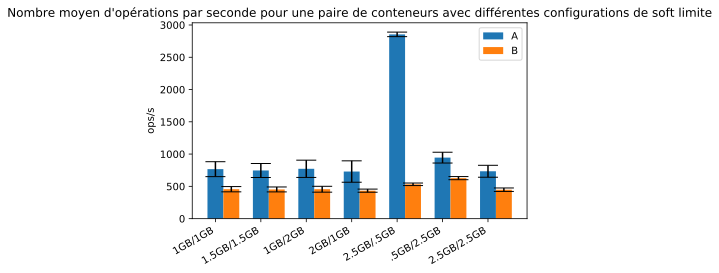

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'pair'
# Since there is sometimes two files with the same size for container A there was a risk of 
# confusion.
# But the timestamp of container_b files can help to guess the correct one.
A_FILES = ['%s/container_a_reverent_tu_1G.out.csv' % DIR, '%s/container_a_sad_noyce_1500M.out.csv' % DIR, '%s/container_a_thirsty_hermann_1G.out.csv' % DIR, '%s/container_a_relaxed_rubin_2G.out.csv' % DIR, '%s/container_a_stupefied_dewdney_2500M.out.csv' % DIR, '%s/container_a_sad_cray_500M.out.csv' % DIR, '%s/container_a_kind_blackburn_2500M.out.csv' % DIR]
B_FILES = ['%s/container_b_blissful_swanson_1G.out.csv' % DIR, '%s/container_b_cocky_mccarthy_1500M.out.csv' % DIR, '%s/container_b_stoic_germain_2G.out.csv' % DIR, '%s/container_b_elastic_sinoussi_1G.out.csv' % DIR, '%s/container_b_upbeat_bohr_500M.out.csv' % DIR, '%s/container_b_awesome_agnesi_2500M.out.csv' % DIR, '%s/container_b_nervous_sammet_2500M.out.csv' % DIR]

# lists for the bar chart (A is first container, B is second (see above)).
A_means = []
A_stds = []

B_means = []
B_stds = []

for file in A_FILES:
    # Get data from CSV file.
    df = pd.read_csv(file, ';')
    values = df.values

    # Computing mean and standard deviation.
    # values is a numpy.ndarray i.e an array of tuples.
    # mean() and std() take an axis as argument and return a tuple.
    # [1] permits to obtain second member of tuple.
    A_means.append(values.mean(0)[1])
    A_stds.append(values.std(0)[1])

for file in B_FILES:
    df = pd.read_csv(file, ';')
    values = df.values

    B_means.append(values.mean(0)[1])
    B_stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['1GB/1GB', '1.5GB/1.5GB', '1GB/2GB', '2GB/1GB', '2.5GB/.5GB', '.5GB/2.5GB', '2.5GB/2.5GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
# The width of the bars.
WIDTH = .35
group0 = ax.bar(x_pos, A_means, WIDTH, yerr = A_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
group1 = ax.bar(x_pos + WIDTH, B_means, WIDTH, yerr = B_stds, align = 'center', capsize = 10)
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.legend((group0[0], group1[0]), ('A', 'B'))
ax.set_title("Nombre moyen d'opérations par seconde pour une paire de conteneurs avec différentes configurations de soft limite")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

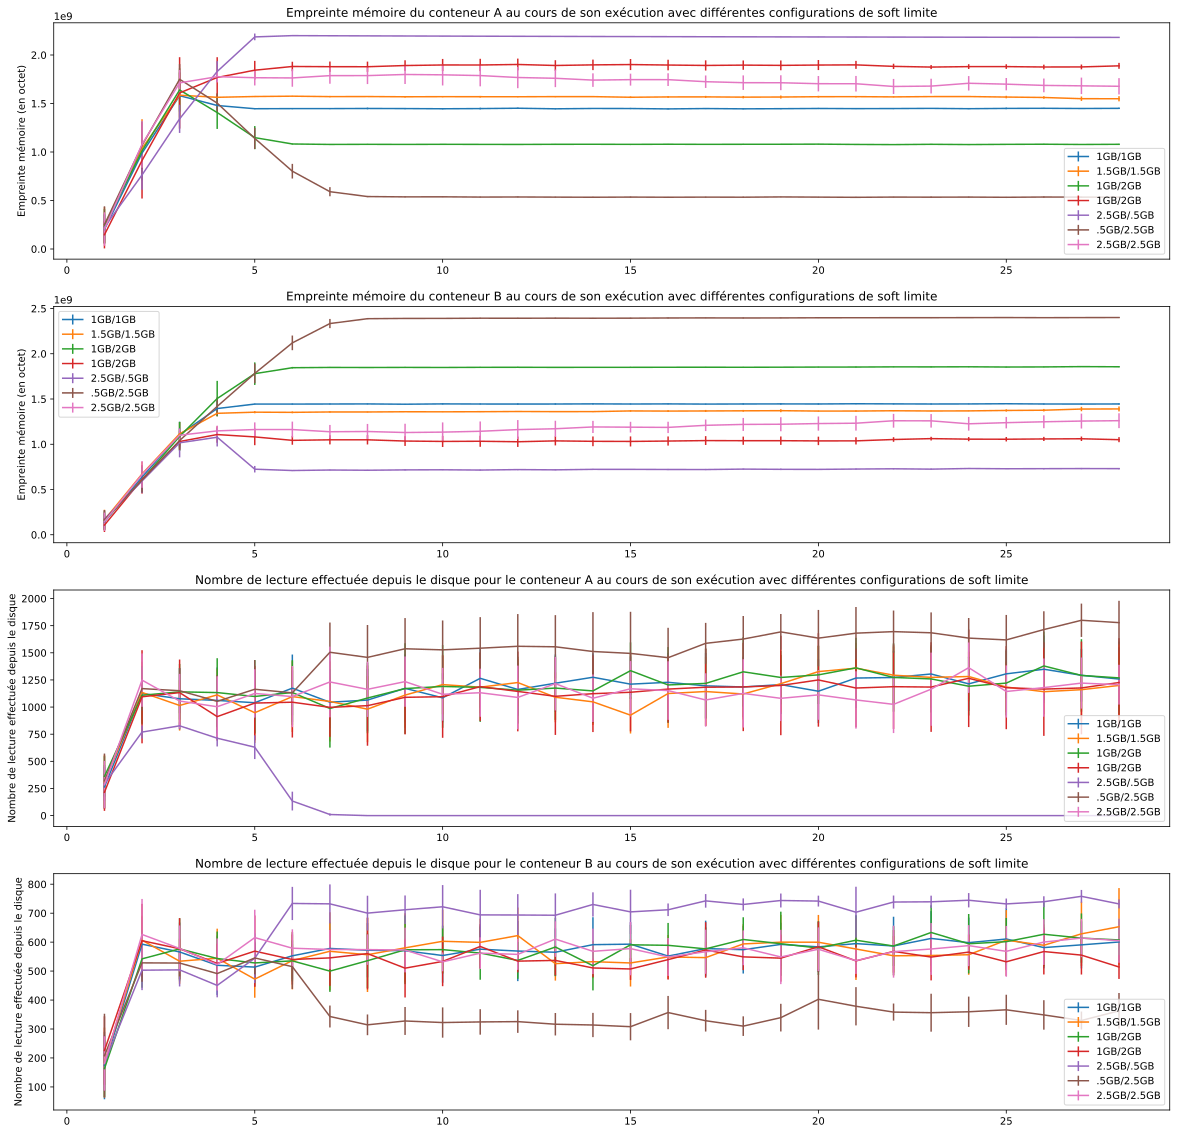

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

LABELS = ['1GB/1GB', '1.5GB/1.5GB', '1GB/2GB', '1GB/2GB', '2.5GB/.5GB', '.5GB/2.5GB', '2.5GB/2.5GB']

DIR = 'pair'
# Since there is two *_1G files for container A there was a risk of confusion.
# But the timestamp of container_b files can help to guess the correct one.
A_FILES = ['%s/container_a_reverent_tu_1G.stats.csv' % DIR, '%s/container_a_sad_noyce_1500M.stats.csv' % DIR, '%s/container_a_thirsty_hermann_1G.stats.csv' % DIR, '%s/container_a_relaxed_rubin_2G.stats.csv' % DIR, '%s/container_a_stupefied_dewdney_2500M.stats.csv' % DIR, '%s/container_a_sad_cray_500M.stats.csv' % DIR, '%s/container_a_kind_blackburn_2500M.stats.csv' % DIR]
B_FILES = ['%s/container_b_blissful_swanson_1G.stats.csv' % DIR, '%s/container_b_cocky_mccarthy_1500M.stats.csv' % DIR, '%s/container_b_stoic_germain_2G.stats.csv' % DIR, '%s/container_b_elastic_sinoussi_1G.stats.csv' % DIR, '%s/container_b_upbeat_bohr_500M.stats.csv' % DIR, '%s/container_b_awesome_agnesi_2500M.stats.csv' % DIR, '%s/container_b_nervous_sammet_2500M.stats.csv' % DIR]

# Dictionaries initialization.
A_dict = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}}
B_dict = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}}

for file in A_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    # The first record has strange standard deviation values so we do not get it.
    A_dict['usage']['means'].append(values.take(1, axis = 1)[1 : len(values) - 1])
    A_dict['usage']['stds'].append(values.take(2, axis = 1)[1 : len(values) - 1])
    
    A_dict['reads']['means'].append(values.take(3, axis = 1)[1 : len(values) - 1])
    A_dict['reads']['stds'].append(values.take(4, axis = 1)[1 : len(values) - 1])

for file in B_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    # The first record has strange standard deviation values so we do not get it.
    B_dict['usage']['means'].append(values.take(1, axis = 1)[1 : len(values) - 1])
    B_dict['usage']['stds'].append(values.take(2, axis = 1)[1 : len(values) - 1])
    
    B_dict['reads']['means'].append(values.take(3, axis = 1)[1 : len(values) - 1])
    B_dict['reads']['stds'].append(values.take(4, axis = 1)[1 : len(values) - 1])

# xtick labels for the bar chart.
x_pos = np.arange(len(range(30)))

# Axis and figure initialization. We need four axis:
# 1. Memory usage of container A.
# 2. Memory usage of container B.
# 3. Reads from disk of container A.
# 4. Reads from disk of container B.
fig, (A_usage_ax, B_usage_ax, A_reads_ax, B_reads_ax) = plt.subplots(nrows = 4, figsize = (20, 20))

for i in range(len(LABELS)):
    A_usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], A_dict['usage']['means'][i], yerr = A_dict['usage']['stds'][i], label = LABELS[i])
    A_reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], A_dict['reads']['means'][i], yerr = A_dict['reads']['stds'][i], label = LABELS[i])
    
    B_usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], B_dict['usage']['means'][i], yerr = B_dict['usage']['stds'][i], label = LABELS[i])
    B_reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], B_dict['reads']['means'][i], yerr = B_dict['reads']['stds'][i], label = LABELS[i])
    
A_usage_ax.legend()
A_usage_ax.set_ylabel('Empreinte mémoire (en octet)')
A_usage_ax.set_title('Empreinte mémoire du conteneur A au cours de son exécution avec différentes configurations de soft limite')

A_reads_ax.legend()
A_reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
A_reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur A au cours de son exécution avec différentes configurations de soft limite')

B_usage_ax.legend()
B_usage_ax.set_ylabel('Empreinte mémoire (en octet)')
B_usage_ax.set_title('Empreinte mémoire du conteneur B au cours de son exécution avec différentes configurations de soft limite')

B_reads_ax.legend()
B_reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
B_reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur B au cours de son exécution avec différentes configurations de soft limite')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Lorsque les conteneurs sont exécutés de concert aucun d'entre eux n'obtient de bonnes performances sauf le conteneur A dans le cas où sa `soft` limite est fixée à 2.5GB et où le conteneur B voit la sienne fixée à .5GB.

L'absence de bonne performance peut s'expliquer par le fait qu'aucun conteneur ne s'exécute avec son empreinte mémoire idéale sauf le conteneur A dans le cas sus-cité.

Les conteneurs effectuent donc beaucoup de lecture depuis le disque ce qui ruine leurs performances.

On peut néanmoins remarquer que le conteneur B voit ses performances légèrement augmenter lorsque sa `soft` limite est fixée à 2.5GB et que celle de A est fixée à .5GB.
Son empreinte mémoire tend alors vers 2.5GB tandis que son nombre de lecture diminue (plus proche de 300 lectures par seconde comparées à 500 dans les autres configurations).

La différence de valeur de performance pour le conteneur A pour la `soft` limite fixée à 2.5GB et lorsqu'il est exécuté seul (3000 opérations par seconde contre 4000) peut s'expliquer par le fait qu'il met plus de temps à stabiliser son nombre de lecture disque à 0 (5 secondes quand il est exécuté seul contre 7).

Lorsque les deux `soft` limites ont été fixées à 2.5GB aucun conteneur n'est favorisé donc leurs performances sont faibles.

#### Conclusion
Le conteneur B n'obtient jamais de bonne performance car son fichier de 10GB ne peut pas rentrer en mémoire. De plus, les deux fichiers sont en conflit car pour lire un bloc de l'un il faut évincer un bloc de l'autre.

Lorsque les `soft` limites sont à peu près égales aucun conteneur n'obtient de bonnes performances.

Ce cas montre qu'il n'est pas possible de satisfaire les deux conteneurs à la fois. Néanmoins il peut être intéréssant de remarquer que puisque le conteneur B n'arrive jamais à atteindre de bonnes performances il peut être "moins pire" de privilégier le conteneur A.

Le dernier cas montre que le noyau n'est pas capable de favorisé un conteneur plutôt qu'un autre.